In [1]:
"""Manual spark configuration based on the default Spark configuration from the NXCALS bundle
and https://gitlab.cern.ch/msobiesz/spark-pipelines/-/blob/master/NXCALS-example-for-DAaaS.ipynb.
Used unless the spark context is already created. (outside of SWAN service or pyspark)
"""

if "spark" not in locals() and "spark" not in globals():
    import os
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession

    nxcals_jars = os.getenv("NXCALS_JARS")
    conf = SparkConf()
    conf.set("spark.master", "yarn")
    conf.set("spark.driver.host", "spark-runner.cern.ch")
    conf.set("spark.driver.port", "5001")
    conf.set("spark.blockManager.port", "5101")
    conf.set("spark.ui.port", "5201")
    conf.set("spark.executorEnv.PYTHONPATH", os.getenv("PYTHONPATH"))
    conf.set("spark.executorEnv.LD_LIBRARY_PATH", os.getenv("LD_LIBRARY_PATH"))
    conf.set("spark.executorEnv.JAVA_HOME", os.getenv("JAVA_HOME"))
    conf.set("spark.executorEnv.SPARK_HOME", os.getenv("SPARK_HOME"))
    conf.set("spark.executorEnv.SPARK_EXTRA_CLASSPATH", os.getenv("SPARK_DIST_CLASSPATH"))
    conf.set("spark.driver.extraClassPath", nxcals_jars)
    conf.set("spark.executor.extraClassPath", nxcals_jars)
    conf.set(
        "spark.driver.extraJavaOptions",
        "-Dservice.url=https://cs-ccr-nxcals5.cern.ch:19093,https://cs-ccr-nxcals5.cern.ch:19094,"
        "https://cs-ccr-nxcals6.cern.ch:19093,https://cs-ccr-nxcals6.cern.ch:19094,"
        "https://cs-ccr-nxcals7.cern.ch:19093,https://cs-ccr-nxcals7.cern.ch:19094,"
        "https://cs-ccr-nxcals8.cern.ch:19093,https://cs-ccr-nxcals8.cern.ch:19094,"
        "https://cs-ccr-nxcalsstr4.cern.ch:19093,https://cs-ccr-nxcalsstr5.cern.ch:19093",
    )

    sc = SparkContext(conf=conf)
    spark = SparkSession(sc)

<h1><center>Analysis of PNO.a6 HWC Test in an RQ Circuit</center></h1>
<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/raw/master/figures/rq/RQ.png" width=75%>

Before performing this test, PNO.B3 must be passed and validated.

PNO.A6 is a current cycle with three current levels (I_INJECTION, I_PNO_INTERM, I_PNO) during TIME_INTERM_1, TIME_INTERM_2 and TIME_PNO respectively. PNO.A6 can be performed with calorimetric measurement (original purpose). In case of calorimetric measurement, the cryogenic cooling must be stable and maintained constant during the whole cycle. The aim of this test is to check the performance of the current leads and the stability of the circuit at I_PNO, and, in case of calorimetric measurements, to detect abnormal heating in the magnets environment.

The current to earth and the current error from the power converter are checked during the sequence.

<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/raw/master/figures/rq/PNO_current.png" width=75%>

The required analysis and signatures are listed below.

|Responsible|Type of analysis|Criterion|
|-----------|----------------|---------|
|PC|Automatic analysis on earth current and error current|I_EARTH_PNO_A6 < I_EARTH_MAX and I_ERR_PNO_A6 < I_ERR_MAX|
|MP3|Splice signals|R_bus<10 nOhm R_mag<50 nOhm|
|MP3|Current lead|46 < TT891A < 54K|
|MP3|Current lead|Abs(U_RES)< 40mV and no drift|
|MP3|Current lead|Abs(U_HTS) < 0.5mV|

source: Powering Procedure and Acceptance Criteria for the 13 kA Quadrupole (RQD-RQF) Circuits, MP3 Procedure, <a href="https://edms.cern.ch/document/874714">https://edms.cern.ch/document/874714</a> (Please follow this link for the latest version)

# Analysis Assumptions
- We consider standard analysis scenarios, i.e., all signals can be queried. Depending on what signal is missing, an analysis can raise a warning and continue or an error and abort the analysis.
- It is recommended to execute each cell one after another. However, since the signals are queried prior to an analysis, any order of execution is allowed. In case an analysis cell is aborted, the following ones may not be executed (e.g. I\_MEAS not present). 

# Plot Convention
- Scales are labeled with signal name followed by a comma and a unit in the square bracket, e.g., I_MEAS, [A]
- If a reference signal is present, it is represented with a dashed line
- If the main current is present, its axis is on the left. Remaining signals are attached to the axis on the right. The legend of these signals is located on the lower left and upper right, respectively.
- The grid comes from the left axis
- Title contains timestamp, circuit name, signal name allowing for re-access the signal.
- The plots assigned to the left scale got colors: blue (C0) and orange (C1). Plots presented on the right have colors red (C2) and green (C3).
- Each plot has an individual time-synchronization mentioned explicitly in the description.
- If an axis has a single signal, change color of the label to match the signal's color. Otherwise, the label color is black.


# 0. Initialise Working Environment

In [2]:
# External libraries
print("Loading (1/11)")
import sys
import pandas as pd

print("Loading (2/11)")
from IPython.display import display, Javascript, clear_output

# Internal libraries
print("Loading (3/11)")
import lhcsmapi

print("Loading (4/11)")
from lhcsmapi.Time import Time

print("Loading (5/11)")
from lhcsmapi.Timer import Timer

print("Loading (6/11)")
from lhcsmapi.analysis.RqCircuitQuery import RqCircuitQuery

print("Loading (7/11)")
from lhcsmapi.analysis.RqCircuitAnalysis import RqCircuitAnalysis

print("Loading (8/11)")
from lhcsmapi.analysis.report_template import apply_report_template

print("Loading (9/11)")
from lhcsmapi.gui.hwc.HwcSearchModuleMediator import HwcSearchModuleMediator

print("Loading (10/11)")
from lhcsmapi.pyedsl.PlotBuilder import create_hwc_plot_title_with_circuit_name

print("Loading (11/11)")
from lhcsmapi.analysis.expert_input import get_expert_decision

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

clear_output()
lhcsmapi.get_lhcsmapi_version()
lhcsmapi.get_lhcsmhwc_version("../__init__.py")
print("Analysis performed by %s" % HwcSearchModuleMediator.get_user())

Analysis executed with lhc-sm-api version: 1.5.17
Analysis executed with lhc-sm-hwc notebooks version: 1.5.65
Analysis performed by root


# 1. User Input
1. Copy code from AccTesting and paste into an empty cell below
<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/-/raw/master/figures/swan-manual-acctesting-integration.png">

    - If you only want to test the notebook only for the copy&paste feature (without opening the AccTesting), please copy and execute the code below
    ```
    hwc_test = 'PNO.a6'
    circuit_name = 'RQD.A12'
    campaign = 'HWC_2017'
    t_start = '2017-04-26 21:32:51.083'
    t_end = '2017-04-27 01:54:29.036'
    ```

2. To analyze a historical test with a browser GUI, copy and execute the following code in the cell below
```
circuit_type = 'RQ'
hwc_test = 'PNO.a6'
hwcb = HwcSearchModuleMediator(circuit_type=circuit_type, hwc_test=hwc_test, hwc_summary_path='/eos/project/l/lhcsm/hwc/HWC_Summary.csv')
```

    - After opening the browser GUI, choose a circuit name in order to display HWC test with, campaign name as well as start and end time

In [3]:
# Parameters
hwc_test = "PNO.a6"
circuit_name = "RQD.A12"
campaign = "HWC_2017"
t_start = "2017-04-26 21:32:51.083"
t_end = "2017-04-27 01:54:29.036"
is_automatic = True

In [4]:
print(
    "hwc_test = '%s'\ncircuit_name = '%s'\ncampaign = '%s'\nt_start = '%s'\nt_end = '%s'"
    % (hwc_test, circuit_name, campaign, t_start, t_end)
)

hwc_test = 'PNO.a6'
circuit_name = 'RQD.A12'
campaign = 'HWC_2017'
t_start = '2017-04-26 21:32:51.083'
t_end = '2017-04-27 01:54:29.036'


# 2. Query All Signals Prior to Analysis

In [5]:
circuit_type = "RQ"
if "hwcb" in locals():
    circuit_name = hwcb.get_circuit_name()
    t_start = Time.to_unix_timestamp(hwcb.get_start_time())
    t_end = Time.to_unix_timestamp(hwcb.get_end_time())
    is_automatic = hwcb.is_automatic_mode()
else:
    t_start = Time.to_unix_timestamp(t_start)
    t_end = Time.to_unix_timestamp(t_end)
    is_automatic = False

circuit_names = [
    circuit_name if "RQD" in circuit_name else circuit_name.replace("F", "D"),
    circuit_name if "RQF" in circuit_name else circuit_name.replace("D", "F"),
]

rqd_query = RqCircuitQuery(circuit_type, circuit_names[0], max_executions=4)
rqf_query = RqCircuitQuery(circuit_type, circuit_names[1], max_executions=4)
rq_analysis = RqCircuitAnalysis(circuit_type, None, is_automatic=is_automatic)

with Timer():
    # PC
    i_meas_nxcals_dfs = RqCircuitQuery(circuit_type, circuit_names).query_signal_nxcals(
        t_start, t_end, t0=t_start, system="PC", signal_names="I_MEAS", spark=spark
    )
    i_meas_raw_nxcals_dfs = RqCircuitQuery(circuit_type, circuit_names).query_raw_signal_nxcals(
        t_start, t_end, system="PC", signal_names="I_MEAS", spark=spark
    )
    plateau_start, plateau_end = RqCircuitQuery(circuit_type, circuit_names).calculate_current_plateau_start_end(
        t_start, t_end, i_meas_threshold=500, min_duration_in_sec=600, time_shift_in_sec=(240, 60), spark=spark
    )

    # BUSBAR
    from lhcsmapi.analysis.busbar.BusbarResistanceAnalysis import MultipleBusbarResistanceAnalysis

    # # RQD
    u_res_rqd_feature_df, i_meas_rqd_feature_df = rqd_query.get_busbar_resistances(
        Time.to_unix_timestamp(t_start),
        Time.to_unix_timestamp(t_end),
        plateau_start,
        plateau_end,
        signal_name="U_RES",
        spark=spark,
    )
    res_busbar_rqd_row_df = MultipleBusbarResistanceAnalysis.calculate_resistance(
        rq_analysis,
        i_meas_rqd_feature_df,
        u_res_rqd_feature_df,
        "U_RES",
        Time.to_unix_timestamp(t_start),
        circuit_names[0],
    )
    res_busbar_rqd_df = rq_analysis.convert_to_col(res_busbar_rqd_row_df, signal_name="U_RES")
    # # RQF
    u_res_rqf_feature_df, i_meas_rqf_feature_df = rqf_query.get_busbar_resistances(
        Time.to_unix_timestamp(t_start),
        Time.to_unix_timestamp(t_end),
        plateau_start,
        plateau_end,
        signal_name="U_RES",
        spark=spark,
    )
    res_busbar_rqf_row_df = MultipleBusbarResistanceAnalysis.calculate_resistance(
        rq_analysis,
        i_meas_rqf_feature_df,
        u_res_rqf_feature_df,
        "U_RES",
        Time.to_unix_timestamp(t_start),
        circuit_names[1],
    )
    res_busbar_rqf_df = rq_analysis.convert_to_col(res_busbar_rqf_row_df, signal_name="U_RES")

    # MAGNET
    # # RQD
    u_mag_rqd_feature_df, i_meas_rqd_feature_df = rqd_query.get_busbar_resistances(
        Time.to_unix_timestamp(t_start),
        Time.to_unix_timestamp(t_end),
        plateau_start,
        plateau_end,
        signal_name="U_MAG",
        spark=spark,
    )
    res_magnet_rqd_row_df = MultipleBusbarResistanceAnalysis.calculate_resistance(
        rq_analysis,
        i_meas_rqd_feature_df,
        u_mag_rqd_feature_df,
        "U_MAG",
        Time.to_unix_timestamp(t_start),
        circuit_names[0],
    )
    res_magnet_rqd_df = rq_analysis.convert_to_col(res_magnet_rqd_row_df, signal_name="U_MAG")
    # # RQF
    u_mag_rqf_feature_df, i_meas_rqf_feature_df = rqf_query.get_busbar_resistances(
        Time.to_unix_timestamp(t_start),
        Time.to_unix_timestamp(t_end),
        plateau_start,
        plateau_end,
        signal_name="U_MAG",
        spark=spark,
    )
    res_magnet_rqf_row_df = MultipleBusbarResistanceAnalysis.calculate_resistance(
        rq_analysis,
        i_meas_rqf_feature_df,
        u_mag_rqf_feature_df,
        "U_MAG",
        Time.to_unix_timestamp(t_start),
        circuit_names[1],
    )
    res_magnet_rqf_df = rq_analysis.convert_to_col(res_magnet_rqf_row_df, signal_name="U_MAG")

    # DFB
    # # RQD
    u_res_rqd_nxcals_dfs = rqd_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system="LEADS", signal_names="U_RES", spark=spark
    )
    u_hts_rqd_nxcals_dfs = rqd_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system="LEADS", signal_names="U_HTS", spark=spark
    )

    tt891a_rqd_nxcals_dfs = rqd_query.query_dfb_signal_nxcals(
        t_start, t_end, system="LEADS_WINCCOA", signal_names="TT891A", spark=spark
    )
    tt893_rqd_nxcals_dfs = rqd_query.query_dfb_signal_nxcals(
        t_start, t_end, system="LEADS_WINCCOA", signal_names="TT893", spark=spark
    )
    # # RQF
    u_res_rqf_nxcals_dfs = rqf_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system="LEADS", signal_names="U_RES", spark=spark
    )
    u_hts_rqf_nxcals_dfs = rqf_query.query_signal_nxcals(
        t_start, t_end, t0=t_start, system="LEADS", signal_names="U_HTS", spark=spark
    )

    tt891a_rqf_nxcals_dfs = rqf_query.query_dfb_signal_nxcals(
        t_start, t_end, system="LEADS_WINCCOA", signal_names="TT891A", spark=spark
    )
    tt893_rqf_nxcals_dfs = rqf_query.query_dfb_signal_nxcals(
        t_start, t_end, system="LEADS_WINCCOA", signal_names="TT893", spark=spark
    )

Elapsed: 793.043 s.


# 3. Circuit Parameters Table

In [6]:
rq_analysis.display_parameters_table(circuit_names[0])

Circuit name  Number of apertures Beam 1 Beam 2 RQF B1/B2 RQD B1/B2  \
0    RQD/F.A12                   47    Ext    Int  Odd/Even  Even/Odd   

   Inductance [H]  EE Resistance [ohm]  
0          0.2744               0.0066

# 4. Power Converter
## 4.1. Plot of the Power Converter Main Current


*GRAPHS*:

- t = 0 s corresponds to the start of the test
- Orange box(es) represent period(s) of time with constant current used for calculation of busbar resistance and DFB thresholds

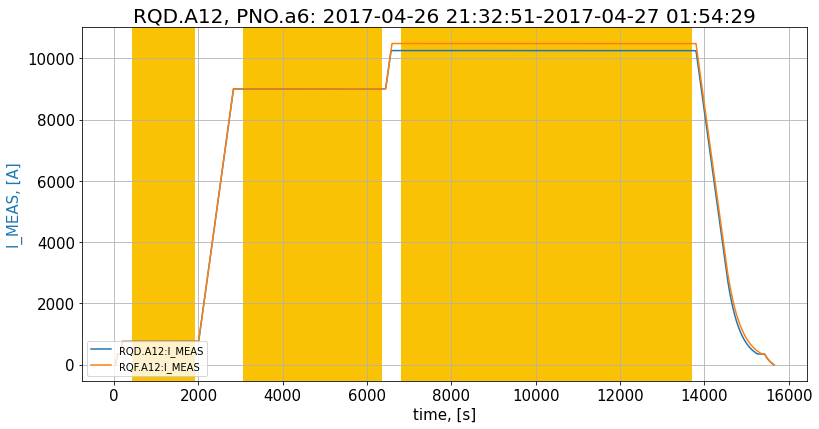

In [7]:
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 80
mpl.rcParams["figure.dpi"] = 80
%matplotlib inline
title = "%s, %s: %s-%s" % (
    circuit_name,
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
i_meas_nxcals_dfs[0] = i_meas_nxcals_dfs[0].rename(
    columns={i_meas_nxcals_dfs[0].columns[0]: "%s:I_MEAS" % (circuit_names[0])}
)
i_meas_nxcals_dfs[1] = i_meas_nxcals_dfs[1].rename(
    columns={i_meas_nxcals_dfs[1].columns[0]: "%s:I_MEAS" % (circuit_names[1])}
)
rq_analysis.plot_i_meas_with_current_plateau(
    i_meas_nxcals_dfs,
    t0=i_meas_raw_nxcals_dfs[0].index[0],
    plateau_start=plateau_start,
    plateau_end=plateau_end,
    title=title,
)

# 5. Busbar
## 5.1. Busbar Resistance

*ANALYSIS*:

- Calculation of the busbar resistance as the slope of a linear fit of U,I curve obtained from the corresponding mean alues of the voltage and current

*CRITERIA*:

- Check if the busbar resistance is below 10 nOhm

*GRAPHS*:

- The busbar resistance, R
- The green box denotes the validity region of the busbar resostance (0, 10] nOhm

- RQD

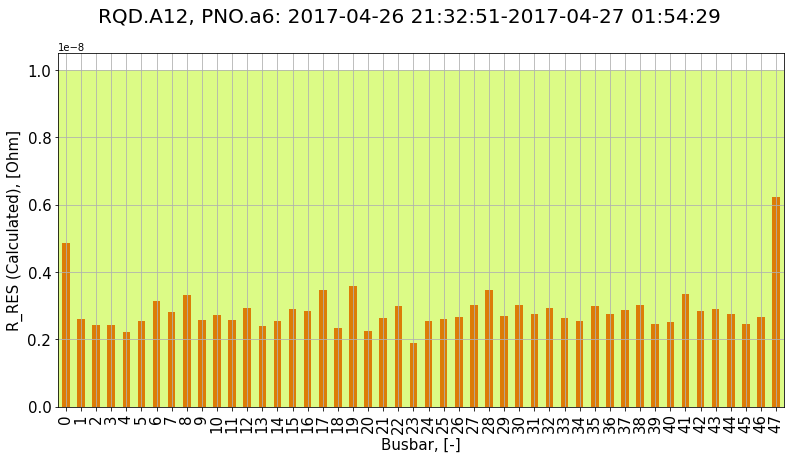

In [8]:
title = "%s, %s: %s-%s" % (
    circuit_names[0],
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
res_busbar_rqd_outliers_df = rq_analysis.analyze_busbar_magnet_resistance(
    res_busbar_rqd_df, signal_name="R_RES", value_max=10e-9, title=title
)

In [9]:
RqCircuitQuery.query_and_plot_outlier_voltage(
    res_busbar_rqd_outliers_df.reset_index(),
    t_start,
    t_end,
    i_meas_raw_nxcals_dfs[0].index[0],
    plateau_start,
    plateau_end,
    spark=spark,
)

All resistances within the range.


In [10]:
rqd_busbar_metadata_resistance_df = rq_analysis.merge_busbar_metadata_with_resistance(
    res_busbar_rqd_df, circuit_type, circuit_names
)
rq_analysis.display_busbar_metadata_resistance_with_threshold(rqd_busbar_metadata_resistance_df, threshold=10e-9)

- RQF

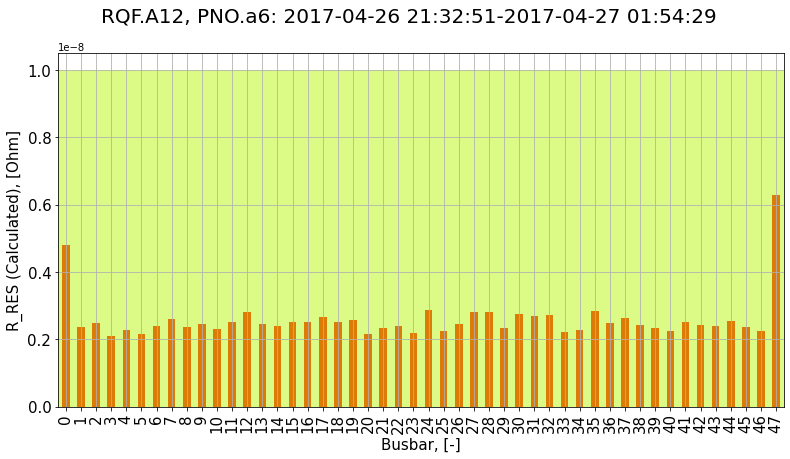

In [11]:
title = "%s, %s: %s-%s" % (
    circuit_names[1],
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
res_busbar_rqf_outliers_df = rq_analysis.analyze_busbar_magnet_resistance(
    res_busbar_rqf_df, signal_name="R_RES", value_max=10e-9, title=title
)

In [12]:
RqCircuitQuery.query_and_plot_outlier_voltage(
    res_busbar_rqf_outliers_df.reset_index(),
    t_start,
    t_end,
    i_meas_raw_nxcals_dfs[0].index[0],
    plateau_start,
    plateau_end,
    spark=spark,
)

All resistances within the range.


In [13]:
rqf_busbar_metadata_resistance_df = rq_analysis.merge_busbar_metadata_with_resistance(
    res_busbar_rqf_df, circuit_type, circuit_names
)
rq_analysis.display_busbar_metadata_resistance_with_threshold(rqf_busbar_metadata_resistance_df, threshold=10e-9)

## 5.2. Magnet Resistance

*ANALYSIS*:

- Calculation of the busbar resistance as the slope of a linear fit of U,I curve obtained from the corresponding mean alues of the voltage and current

*CRITERIA*:

- Check if the busbar resistance is below 50 nOhm

*GRAPHS*:

- The busbar resistance, R
- The green box denotes the validity region of the busbar resostance (0, 50] nOhm

- RQD

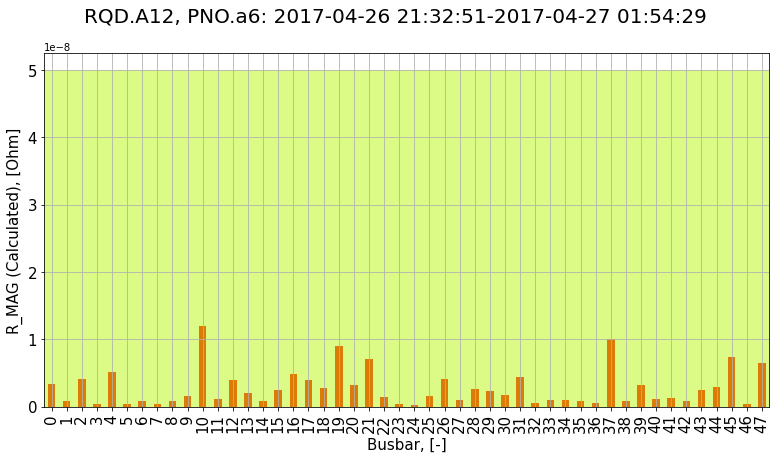

In [14]:
title = "%s, %s: %s-%s" % (
    circuit_names[0],
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
res_magnet_rqd_outliers_df = rq_analysis.analyze_busbar_magnet_resistance(
    res_magnet_rqd_df, signal_name="R_MAG", value_max=50e-9, title=title
)

In [15]:
RqCircuitQuery.query_and_plot_outlier_voltage(
    res_magnet_rqd_outliers_df.reset_index(),
    t_start,
    t_end,
    i_meas_raw_nxcals_dfs[0].index[0],
    plateau_start,
    plateau_end,
    spark=spark,
)

All resistances within the range.


In [16]:
rqd_magnet_metadata_resistance_df = rq_analysis.merge_busbar_metadata_with_resistance(
    res_magnet_rqd_df, circuit_type, circuit_names, res_col="R_MAG"
)
rq_analysis.display_busbar_metadata_resistance_with_threshold(
    rqd_magnet_metadata_resistance_df, threshold=50e-9, res_col="R_MAG"
)

- RQF

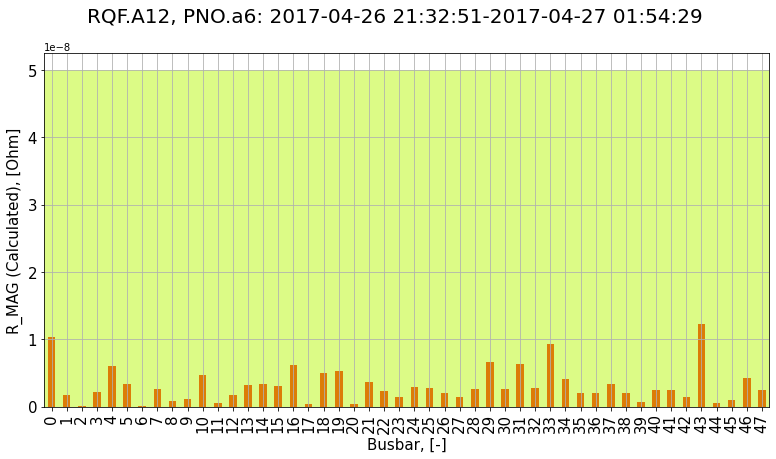

In [17]:
title = "%s, %s: %s-%s" % (
    circuit_names[1],
    hwc_test,
    Time.to_string(t_start).split(".")[0],
    Time.to_string(t_end).split(".")[0],
)
res_magnet_rqf_outliers_df = rq_analysis.analyze_busbar_magnet_resistance(
    res_magnet_rqf_df, signal_name="R_MAG", value_max=50e-9, title=title
)

In [18]:
RqCircuitQuery.query_and_plot_outlier_voltage(
    res_magnet_rqf_outliers_df.reset_index(),
    t_start,
    t_end,
    i_meas_raw_nxcals_dfs[0].index[0],
    plateau_start,
    plateau_end,
    spark=spark,
)

All resistances within the range.


In [19]:
rqf_magnet_metadata_resistance_df = rq_analysis.merge_busbar_metadata_with_resistance(
    res_magnet_rqf_df, circuit_type, circuit_names, res_col="R_MAG"
)
rq_analysis.display_busbar_metadata_resistance_with_threshold(
    rqf_magnet_metadata_resistance_df, threshold=50e-9, res_col="R_MAG"
)

# 6. DFB
## 6.1. DFB Voltage - U_RES

*CRITERIA*:  
- Check if, at constant current, U_RES is constant (no drift < 2mV/h)
- Check if U_RES is in [-40, 40] mV

*GRAPHS*:  

- t = 0 s corresponds to the FGC timestamp

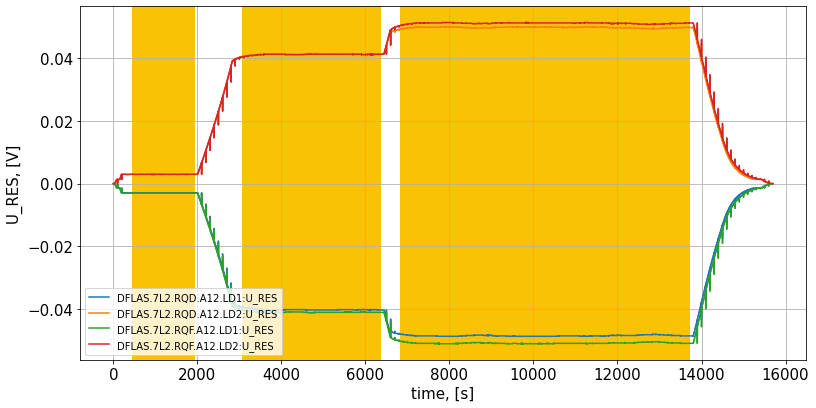

In [20]:
RqCircuitAnalysis.assert_u_res_min_max_slope(
    u_res_rqd_nxcals_dfs + u_res_rqf_nxcals_dfs,
    plateau_start,
    plateau_end,
    Time.to_unix_timestamp(t_start),
    slope_range=(-2, 2),
);

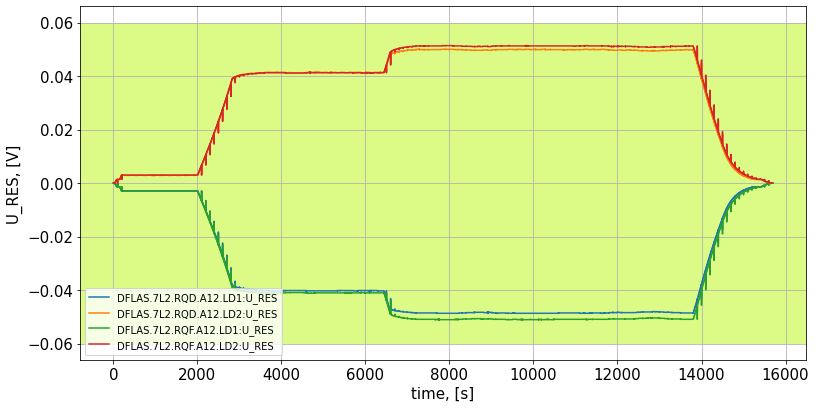

In [21]:
RqCircuitAnalysis.assert_u_res_min_max_value(u_res_rqd_nxcals_dfs + u_res_rqf_nxcals_dfs, value_range=(-60e-3, 60e-3));

## 6.2. DFB Voltage - U_HTS

*CRITERIA*:  
- Check if U_HTS is below 50% of the threshold -> U_HTS in [-0.5, 0.5] mV

*GRAPHS*:  

- t = 0 s corresponds to the FGC timestamp


DFLAS.7L2.RQD.A12.LD2:U_HTS outside of the [-0.0005, 0.0005] threshold


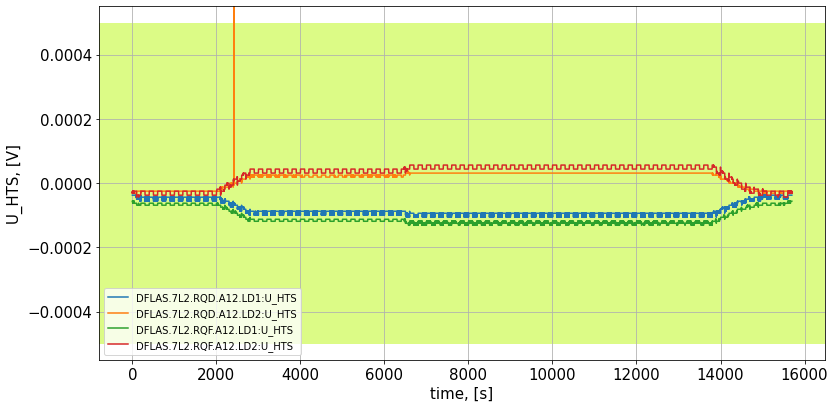

In [22]:
RqCircuitAnalysis.assert_u_hts_min_max_value(u_hts_rqd_nxcals_dfs + u_hts_rqf_nxcals_dfs, value_range=(-0.5e-3, 0.5e-3));

## 6.3. DFB Temperature - TT893.TEMPERATURECALC

*CRITERIA*:

- Check if the temperature is over the dew point, but not overheated -> 280 K < TT893 < 320 K, even without current

*GRAPHS*:

- Temperature at the top of the current lead on the right axis, TT893.TEMPERATURECALC
- Green box denotes the temperature validity region [280, 320] K of the temperature at the top of the current lead
- t = 0 s corresponds to the start time of the test

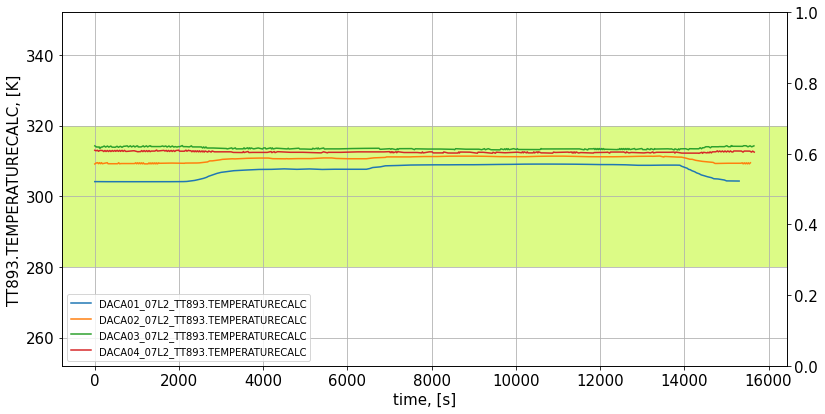

In [23]:
RqCircuitAnalysis.assert_tt893_min_max_value(tt893_rqd_nxcals_dfs + tt893_rqf_nxcals_dfs, value_range=(280, 320));

## 6.4. DFB Temperature - TT891A.TEMPERATURECALC

*CRITERIA*:

- Check if the temperature is regulated around 50 K -> 46 K < TT891A < 54 K, even without current

*GRAPHS*:

- Temperature between the HTS and resistive part of the current lead on the right axis, TT891A.TEMPERATURECALC
- Green box denotes the temperature validity region [46, 54] K of the temperature at the top of the current lead
- t = 0 s corresponds to the start time of the test


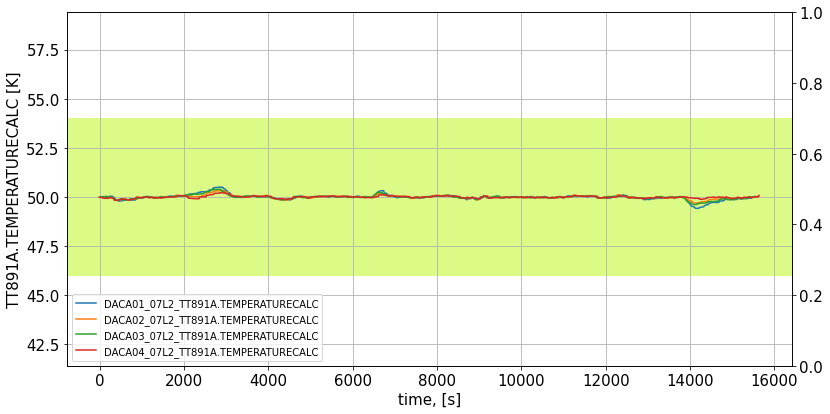

In [24]:
RqCircuitAnalysis.assert_tt891a_min_max_value(tt891a_rqd_nxcals_dfs + tt891a_rqf_nxcals_dfs, value_range=(46, 54));